In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

In [2]:
pd.set_option("display.max_columns", 50)

In [3]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import math

In [ ]:
%load_ext rpy2.ipython

In [6]:
from sklearn.neighbors import RadiusNeighborsRegressor

# Win expectancy

## IPL games

### Import pre-processed all IPL data

In [127]:
df = pd.read_csv("data/df_kaggleAllIpl_preprocessed.csv")
del df['Unnamed: 0']

In [128]:
df.head(5)

,match_id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,2,0,0,0,0,0,2,2,NaN,NaN,NaN


In [129]:
len(df)

150460

### Ball by ball win expectancy

### All IPL games

### locfit

In [130]:
### Ignore tie and DL results
dff = df[ (df['result']=="normal") & (df['dl_applied']==0) ].copy()

### First innings
df1 = dff[dff["inning"]==1].copy()
df1["teamChaseWin"] = df1["bowling_team"]==df1["winner"]
df1["teamChaseWin"] = df1["teamChaseWin"].astype(int)

df1["numRuns"] = df1.groupby(["match_id","inning"]).cumsum()["total_runs"]

df1["ballNum"] = (df1["over"]-1)*6+df1["ball"]
df1["ballNum"][df1['ballNum'] >= 120] = 120
df1["ballsLeft"] = 240 - df1["ballNum"]
df1["pctBallsLeft"] = df1["ballsLeft"]/240

df1["isWicket"] = (~pd.isnull(df1["player_dismissed"])).astype(int)
df1["numWickets"] = df1.groupby(["match_id","inning"]).cumsum()["isWicket"]
df1["pctWicketsLeft"] = (10-df1["numWickets"])/10
df1["runRate"] = df1["numRuns"]/df1["ballNum"]*6

### Second innings
df2 = dff[dff["inning"]==2].copy()
df2["teamChaseWin"] = df2["batting_team"]==df2["winner"]
df2["teamChaseWin"] = df2["teamChaseWin"].astype(int)


df2["ballNum"] = (df2["over"]-1)*6+df2["ball"]
df2["ballNum"][df2['ballNum'] >= 120] = 120
df2["ballsLeft"] = 120 - df2["ballNum"]
df2["pctBallsLeft"] = df2["ballsLeft"]/120

df2["isWicket"] = (~pd.isnull(df2["player_dismissed"])).astype(int)
df2["numWickets"] = df2.groupby(["match_id","inning"]).cumsum()["isWicket"]
df2["pctWicketsLeft"] = (10-df2["numWickets"])/10

tmp = df1.groupby(["match_id"]).sum()["total_runs"].reset_index()
tmp['total_runs'] = tmp['total_runs']+1
tmp.rename(columns={'total_runs':'target'}, inplace=True)
df2 = df2.set_index('match_id').join(tmp.set_index('match_id')).reset_index()
df2["numRuns"] = df2.groupby(["match_id","inning"]).cumsum()["total_runs"]

df2["runsLeft"] = df2["target"]-df2["numRuns"]
df2["requiredRunRate"] = df2["runsLeft"]/df2["ballsLeft"]*6
df2["requiredRunRate"][df2["requiredRunRate"]<=0] = 0
df2 = df2[df2["ballsLeft"]>=1]


/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [131]:
neigh1 = RadiusNeighborsRegressor(radius=3.0, weights='uniform',algorithm='auto', leaf_size=30, p=2, metric='minkowski')
y = df1[["teamChaseWin"]]
#X = df1[["numRuns","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
X = df1[["runRate","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
#X = df1[["runRate","pctBallsLeft","pctWicketsLeft"]]
inn1Model = neigh1.fit(X, y)

neigh2 = RadiusNeighborsRegressor(radius=3.0, weights='uniform',algorithm='auto', leaf_size=30, p=2, metric='minkowski')
y = df2[["teamChaseWin"]]
#X = df2[["runsLeft","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
#X = df2[["requiredRunRate","pctBallsLeft","pctWicketsLeft"]]
X = df2[["requiredRunRate","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
inn2Model = neigh2.fit(X, y)


In [14]:
matchId = 3

dfm1 = df1[df1["match_id"]==matchId]
#X = dfm1[["runRate","pctBallsLeft","pctWicketsLeft"]]
X = dfm1[["runRate","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
we1 = inn1Model.predict(X)

dfm2 = df2[df2["match_id"]==matchId]
#X = dfm2[["requiredRunRate","pctBallsLeft","pctWicketsLeft"]]
X = dfm2[["requiredRunRate","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
we2 = inn2Model.predict(X)

we = np.concatenate((we1, we2))
#plt.plot(we)
dfm = dfm1.append(dfm2)
dfm["we"] = we
#plt.plot(range(len(dfm)),dfm["total_runs"]/20,'*')

In [56]:
dfw = pd.DataFrame()

for m in df['match_id'].unique():
    bat_wpa = {}
    bowl_wpa = {}
    field_wpa = {}
    
    if m%100==0:
        print(m)
        
    dfm = df[df['match_id']==m]

    if dfm['result'].unique()[0]=="normal" and dfm['dl_applied'].unique()[0]==0: ### Ignore ties and matches with DL method
        
        
        ### First innings
        dfm1 = df1[df1["match_id"]==m]
        #X = dfm1[["total_runs","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
        X = dfm1[["runRate","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
        #X = dfm1[["runRate","pctBallsLeft","pctWicketsLeft"]]
        teamChaseWin = dfm1["teamChaseWin"].unique()[0]
        we1 = inn1Model.predict(X)

        
        for b in range(len(dfm1)):  ### Ball by ball for first innings
            if b!=0:
                deltaWe1 = we1[b] - we1[b-1]
                
                if deltaWe1<0:
                    batsman = dfm1.iloc[b]["batsman"]
                    if batsman in bat_wpa:
                        bat_wpa[batsman] += abs(deltaWe1/2)
                        #bat_wpa[batsman] += 1.25*abs(deltaWe1/2)
                    else:
                        bat_wpa[batsman] = abs(deltaWe1/2)
                    
                    bowler = dfm1.iloc[b]["bowler"]
                    if bowler in bowl_wpa:
                        bowl_wpa[bowler] -= abs(deltaWe1/2)
                        #bowl_wpa[bowler] -= 1.25*abs(deltaWe1/2)
                    else:
                        bowl_wpa[bowler] = -abs(deltaWe1/2)
                    
                else:
                    
                    if (not pd.isnull(dfm1.iloc[b]["player_dismissed"])) and (dfm1.iloc[b]["dismissal_kind"]=="run out"):   
                        fielder = dfm1.iloc[b]["fielder"]
                        if fielder in field_wpa:
                            field_wpa[fielder] += abs(deltaWe1/2)
                        else:
                            field_wpa[fielder] = abs(deltaWe1/2)
                        
                        dismissedBatsman = dfm1.iloc[b]["player_dismissed"]
                        if dismissedBatsman in bat_wpa:
                            bat_wpa[dismissedBatsman] -= abs(deltaWe1/2)
                        else:
                            bat_wpa[dismissedBatsman] = -abs(deltaWe1/2)
                    else:  
                        bowler = dfm1.iloc[b]["bowler"]
                        if bowler in bowl_wpa:
                            bowl_wpa[bowler] += abs(deltaWe1/2)
                            #bowl_wpa[bowler] += 0.85*abs(deltaWe1/2)
                        else:
                            bowl_wpa[bowler] = abs(deltaWe1/2)
                        
                        batsman = dfm1.iloc[b]["batsman"]
                        if batsman in bat_wpa:
                            bat_wpa[batsman] -= abs(deltaWe1/2)
                            #bat_wpa[batsman] -= 0.85*abs(deltaWe1/2)
                        else:
                            bat_wpa[batsman] = -abs(deltaWe1/2)
                            
        
        ### Second innings
        dfm2 = df2[df2["match_id"]==m]
        #X = dfm2[["total_runs","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
        X = dfm2[["requiredRunRate","numWickets","ballsLeft","pctBallsLeft","pctWicketsLeft"]]
        #X = dfm2[["requiredRunRate","pctBallsLeft","pctWicketsLeft"]]
        we2 = inn2Model.predict(X)

        for b in range(len(dfm2)):  ### Ball by ball for first innings
            if b!=0:
                deltaWe2 = we2[b] - we2[b-1]
                
                if deltaWe2>0:
                    batsman = dfm2.iloc[b]["batsman"]
                    if batsman in bat_wpa:
                        bat_wpa[batsman] += abs(deltaWe2/2)
                    else:
                        bat_wpa[batsman] = abs(deltaWe2/2)
                    
                    bowler = dfm2.iloc[b]["bowler"]
                    if bowler in bowl_wpa:
                        bowl_wpa[bowler] -= abs(deltaWe2/2)
                    else:
                        bowl_wpa[bowler] = -abs(deltaWe2/2)
                    
                else:
                    
                    if (not pd.isnull(dfm2.iloc[b]["player_dismissed"])) and (dfm2.iloc[b]["dismissal_kind"]=="run out"):   
                        fielder = dfm2.iloc[b]["fielder"]
                        if fielder in field_wpa:
                            field_wpa[fielder] += abs(deltaWe2/2)
                        else:
                            field_wpa[fielder] = abs(deltaWe2/2)
                        
                        dismissedBatsman = dfm2.iloc[b]["player_dismissed"]
                        if dismissedBatsman in bat_wpa:
                            bat_wpa[dismissedBatsman] -= abs(deltaWe2/2)
                        else:
                            bat_wpa[dismissedBatsman] = -abs(deltaWe2/2)
                    else:  
                        bowler = dfm2.iloc[b]["bowler"]
                        if bowler in bowl_wpa:
                            bowl_wpa[bowler] += abs(deltaWe2/2)
                        else:
                            bowl_wpa[bowler] = abs(deltaWe2/2)
                        
                        batsman = dfm2.iloc[b]["batsman"]
                        if batsman in bat_wpa:
                            bat_wpa[batsman] -= abs(deltaWe2/2)
                        else:
                            bat_wpa[batsman] = -abs(deltaWe2/2)
       
    ### Bat wpa
    dfbatwpa = pd.DataFrame.from_dict(bat_wpa, orient='index').reset_index()
    dfbatwpa.rename(columns={'index':'player',0:'bat_wpa'}, inplace=True)
    dfbatwpa["match_id"] = dfm["match_id"].unique()[0]
    dfbatwpa["season"]   = dfm["season"].unique()[0]
    dft1 = dfbatwpa.set_index(['player']).join(dfm.set_index(['batsman']),rsuffix='1')["batting_team"].reset_index().drop_duplicates()
    dft1.dropna(inplace=True)
    dft1.rename(columns={'index':'player','batting_team':'team'}, inplace=True)
    dfbatwpa = dfbatwpa.set_index('player').join(dft1.set_index('player')).reset_index()

    ### Bowl wpa
    dfbowlwpa = pd.DataFrame.from_dict(bowl_wpa, orient='index').reset_index()
    dfbowlwpa.rename(columns={'index':'player',0:'bowl_wpa'}, inplace=True)
    dfbowlwpa["match_id"] = dfm["match_id"].unique()[0]
    dfbowlwpa["season"]   = dfm["season"].unique()[0]
    dft2 = dfbowlwpa.set_index(['player']).join(dfm.set_index(['bowler']),rsuffix='1')["bowling_team"].reset_index().drop_duplicates()
    dft2.dropna(inplace=True)
    dft2.rename(columns={'index':'player','bowling_team':'team'}, inplace=True)
    dfbowlwpa = dfbowlwpa.set_index('player').join(dft2.set_index('player')).reset_index()

    dfwpa = dfbatwpa.set_index(['player','match_id','season','team']).join(dfbowlwpa.set_index(['player','match_id','season','team']),how='outer').reset_index()
    dfw = dfw.append(dfwpa)
                

100
200
300
400
500
600


In [57]:
dfw.head()

,bat_wpa,bowl_wpa,match_id,player,season,team
0,-0.000000,-0.070634,1,A Choudhary,2017,Royal Challengers Bangalore
1,NaN,-0.016856,1,A Nehra,2017,Sunrisers Hyderabad
2,NaN,0.084819,1,B Kumar,2017,Sunrisers Hyderabad
3,0.013117,-0.007033,1,BCJ Cutting,2017,Sunrisers Hyderabad
4,NaN,0.048421,1,Bipul Sharma,2017,Sunrisers Hyderabad


### Per season per player wpa

In [118]:
dfpwpa = dfw[["player","season", "team", "match_id", "bat_wpa", "bowl_wpa"]].copy()
values = {'bat_wpa': 0, 'bowl_wpa': 0}
dfpwpa.fillna(value=values, inplace=True)
dfpwpa["overall_wpa"] = dfpwpa["bat_wpa"] + dfpwpa["bowl_wpa"]
dfpwpa = dfpwpa.groupby(["player","season","team"]).sum().reset_index()
del dfpwpa["match_id"]
dfpwpa.head()

,player,season,team,bat_wpa,bowl_wpa,overall_wpa
0,A Ashish Reddy,2012,Deccan Chargers,-0.157463,0.115587,-0.041875
1,A Ashish Reddy,2013,Sunrisers Hyderabad,0.088102,-0.313077,-0.224974
2,A Ashish Reddy,2015,Sunrisers Hyderabad,0.043077,0.029005,0.072082
3,A Ashish Reddy,2016,Sunrisers Hyderabad,-0.017725,-0.043249,-0.060974
4,A Chandila,2012,Rajasthan Royals,0.000000,0.073675,0.073675


In [124]:
dfpwpa[dfpwpa["season"]==2016].sort_values("bowl_wpa", ascending=False)

,player,season,team,bat_wpa,bowl_wpa,overall_wpa
989,Mustafizur Rahman,2016,Sunrisers Hyderabad,0.000000,0.311256,0.311256
36,A Nehra,2016,Sunrisers Hyderabad,-0.000390,0.250359,0.249970
663,JW Hastings,2016,Kolkata Knight Riders,0.000000,0.163364,0.163364
21,A Mishra,2016,Delhi Daredevils,-0.050934,0.163175,0.112242
439,DS Kulkarni,2016,Gujarat Lions,0.128323,0.160959,0.289282
226,B Kumar,2016,Sunrisers Hyderabad,-0.049931,0.145065,0.095134
261,BCJ Cutting,2016,Sunrisers Hyderabad,0.074543,0.141722,0.216266
174,AR Patel,2016,Kings XI Punjab,0.019765,0.127698,0.147462
1659,YS Chahal,2016,Royal Challengers Bangalore,0.000000,0.126296,0.126296
1276,S Aravind,2016,Royal Challengers Bangalore,0.000000,0.093419,0.093419


### Verify one player's performance in one season

In [125]:
dfpwpa = dfw[["player","season", "team", "match_id", "bat_wpa", "bowl_wpa"]].copy()
values = {'bat_wpa': 0, 'bowl_wpa': 0}
dfpwpa.fillna(value=values, inplace=True)
dfpwpa["overall_wpa"] = dfpwpa["bat_wpa"] + dfpwpa["bowl_wpa"]
#dfpwpa = dfpwpa.groupby(["player","season","team"]).sum().reset_index()
del dfpwpa["match_id"]
dfpwpa[(dfpwpa["season"]==2016) & (dfpwpa["player"]=="JW Hastings")]

,player,season,team,bat_wpa,bowl_wpa,overall_wpa
7,JW Hastings,2016,Kolkata Knight Riders,0.0,0.122808,0.122808
9,JW Hastings,2016,Kolkata Knight Riders,0.0,0.040556,0.040556


### Verify team wpa

In [510]:
dfp = dfw[["season","team","player","match_id","bat_wpa","bowl_wpa"]]
dfp.fillna(0, inplace=True)
dfp.groupby(["season","player"]).sum()["bowl_wpa"].reset_index().sort_values('bowl_wpa',ascending=False)
dfp.groupby(["season","team"]).sum()["bat_wpa"].reset_index().sort_values('bat_wpa',ascending=False)

,season,team,bat_wpa
61,2014.0,Kings XI Punjab,2.573501
59,2014.0,Chennai Super Kings,2.052796
56,2013.0,Royal Challengers Bangalore,1.954743
82,2016.0,Royal Challengers Bangalore,1.700559
7,2008.0,Rajasthan Royals,1.680989
55,2013.0,Rajasthan Royals,1.648165
77,2016.0,Gujarat Lions,1.545889
83,2016.0,Sunrisers Hyderabad,1.417470
24,2010.0,Mumbai Indians,1.404363
28,2011.0,Chennai Super Kings,1.391634


### Other techniques

In [76]:
maxRunRateBins = 300
maxBalls = 240
acc = []
numOccurrences  = np.zeros(shape=(maxBalls,maxRunRateBins,11), dtype='int')
numTeamChaseWin = np.zeros(shape=(maxBalls,maxRunRateBins,11), dtype='int')

for m in df['match_id'].unique():
    
    if m%100==0:
        print(m)
        
    dfm = df[df['match_id']==m]
    
    if dfm['result'].unique()[0]=="normal" and dfm['dl_applied'].unique()[0]==0: ### Ignore ties and matches with DL method
        
        ### Count number of instances when team chasing wins the game
        teamChase = dfm[dfm['inning']==2]['batting_team'].unique()[0]
        winner = dfm['winner'].unique()[0]
        teamChaseWin = 1 if (teamChase==winner) else 0

        ball = 0
        firstInningsRuns = 0
        secondInningsRuns = 0
        firstInningsWickets = 0
        secondInningsWickets = 0
        
        for b in range(len(dfm)):  ### For each ball in the match
            
            innings = dfm.iloc[b]['inning']
            
            if dfm.iloc[b]['wide_runs']==0 and dfm.iloc[b]['noball_runs']==0:  ### Do not count wides/no-balls
                ball += 1
              
            if innings==2 and ball==121:    ### Start of second innings
                target = firstInningsRuns+1
                numBallsRemaining = maxBalls/2
                
            if ball!=0 and innings==1:    ### First innings
                firstInningsRuns += dfm.iloc[b]['total_runs']
                runRate = int(np.around(firstInningsRuns/ball*6, decimals=1)*10)
                #runRate = int(round(firstInningsRuns/ball*6*2)/2*2)
                #runRate = int(round(firstInningsRuns/ball*6))
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    firstInningsWickets += 1
                
                if runRate>=maxRunRateBins:
                    runRate=maxRunRateBins-1
                numOccurrences[ball, runRate, firstInningsWickets] += 1
                numTeamChaseWin[ball, runRate, firstInningsWickets] += teamChaseWin
                acc.append(teamChaseWin)
                
            elif innings==2 and numBallsRemaining>1:  ### Second innings   
                numBallsRemaining = maxBalls-ball
                numRunsRemaining = target-secondInningsRuns
                secondInningsRuns += dfm.iloc[b]['total_runs']
                requiredRunRate = int(np.around(numRunsRemaining/numBallsRemaining*6, decimals=1)*10)
                #requiredRunRate = int(round(numRunsRemaining/numBallsRemaining*6*2)/2*2)
                #requiredRunRate = int(round(numRunsRemaining/numBallsRemaining*6))
                
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    secondInningsWickets += 1
            
                if requiredRunRate >= maxRunRateBins:
                    requiredRunRate = maxRunRateBins-1
                numOccurrences[ball, requiredRunRate, secondInningsWickets] += 1
                numTeamChaseWin[ball, requiredRunRate, secondInningsWickets] += teamChaseWin
                acc.append(teamChaseWin)
            

100
200
300
400
500
600


In [77]:
we = numTeamChaseWin/numOccurrences

C:\Users\Stage\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [78]:
we.tofile("data/we_runrateIncr0.1")

In [79]:
maxRunRateBins = 300
maxBalls = 240

we1 = [0] * 240
we1[0] = 0.5
wpa = {}
accRunRate = []
accWickets = []

for m in [1]: #df['match_id'].unique():
    
    if m%100==0:
        print(m)
        
    dfm = df[df['match_id']==m]
    
    if dfm['result'].unique()[0]=="normal" and dfm['dl_applied'].unique()[0]==0: ### Ignore ties and matches with DL method
        
        ### Count number of instances when team chasing wins the game
        teamChase = dfm[dfm['inning']==2]['batting_team'].unique()[0]
        winner = dfm['winner'].unique()[0]
        teamChaseWin = 1 if (teamChase==winner) else 0

        ball = 0
        firstInningsRuns = 0
        secondInningsRuns = 0
        firstInningsWickets = 0
        secondInningsWickets = 0
        mwpa = []
        
        for b in range(len(dfm)):  ### For each ball in the match
            
            innings = dfm.iloc[b]['inning']
            
            if dfm.iloc[b]['wide_runs']==0 and dfm.iloc[b]['noball_runs']==0:  ### Do not count wides/no-balls
                ball += 1
              
            if innings==2 and ball==121:    ### Start of second innings
                target = firstInningsRuns+1
                numBallsRemaining = maxBalls/2
            
            if ball==0:
                mwpa.append(0.5)
                accRunRate.append(0)
                accFirstInningsWickets.append(0)
                
            if ball!=0 and innings==1:    ### First innings
                firstInningsRuns += dfm.iloc[b]['total_runs']
                runRate = int(np.around(firstInningsRuns/ball*6, decimals=1)*10)
                #runRate = int(round(firstInningsRuns/ball*6*2)/2*2)
                #runRate = int(round(firstInningsRuns/ball*6))

                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    firstInningsWickets += 1
                    
                accRunRate.append(runRate)
                accWickets.append(firstInningsWickets)
                
                if runRate>=maxRunRateBins:
                    runRate=maxRunRateBins-1
                    
                #we1[ball] = we[ball, runRate, firstInningsWickets]
                raw = we[:,runRate, firstInningsWickets]
                raw = [0.5 if math.isnan(x) else x for x in raw]
                filtered = lowess(raw, range(len(raw)), is_sorted=True, frac=0.3)
                we1[ball] = filtered[ball,1]
                deltaWe = we1[ball] - we1[ball-1]
                mwpa.append(we1[ball])
                
                if deltaWe<0:
                    batsman = dfm.iloc[b]["batsman"]
                    if batsman in wpa:
                        wpa[batsman] += abs(deltaWe/2)
                    else:
                        wpa[batsman] = abs(deltaWe/2)
                    
                    bowler = dfm.iloc[b]["bowler"]
                    if bowler in wpa:
                        wpa[bowler] -= abs(deltaWe/2)
                    else:
                        wpa[bowler] = -abs(deltaWe/2)
                    
                else:
                    
                    if (not pd.isnull(dfm.iloc[b]["player_dismissed"])) and (dfm.iloc[b]["dismissal_kind"]=="run out"):   
                        fielder = dfm.iloc[b]["fielder"]
                        if fielder in wpa:
                            wpa[fielder] += abs(deltaWe/2)
                        else:
                            wpa[fielder] = abs(deltaWe/2)
                        
                        dismissedBatsman = dfm.iloc[b]["player_dismissed"]
                        if dismissedBatsman in wpa:
                            wpa[dismissedBatsman] -= abs(deltaWe/2)
                        else:
                            wpa[dismissedBatsman] = -abs(deltaWe/2)
                    else:  
                        bowler = dfm.iloc[b]["bowler"]
                        if bowler in wpa:
                            wpa[bowler] += abs(deltaWe/2)
                        else:
                            wpa[bowler] = abs(deltaWe/2)
                        
                        batsman = dfm.iloc[b]["batsman"]
                        if batsman in wpa:
                            wpa[batsman] -= abs(deltaWe/2)
                        else:
                            wpa[batsman] = -abs(deltaWe/2)
                    
                            
            elif innings==2 and numBallsRemaining>1:  ### Second innings   
                numBallsRemaining = maxBalls-ball
                secondInningsRuns += dfm.iloc[b]['total_runs']
                numRunsRemaining = target-secondInningsRuns
                
                requiredRunRate = int(np.around(numRunsRemaining/numBallsRemaining*6, decimals=1)*10)
                #requiredRunRate = int(round(numRunsRemaining/numBallsRemaining*6*2)/2*2)
                #requiredRunRate = int(round(numRunsRemaining/numBallsRemaining*6))
                
                if not pd.isnull(dfm.iloc[b]['player_dismissed']):
                    secondInningsWickets += 1
            
                if requiredRunRate >= maxRunRateBins:
                    requiredRunRate = maxRunRateBins-1
                    
                accRunRate.append(requiredRunRate)
                accWickets.append(secondInningsWickets)
                
                if numRunsRemaining<=0:
                    we1[ball]=1
                else:
                    #we1[ball] = we[ball, requiredRunRate, secondInningsWickets]
                    raw = we[:,requiredRunRate, secondInningsWickets]
                    ### Fill Nan with 0.5
                    raw = [0.5 if math.isnan(x) else x for x in raw]
                    filtered = lowess(raw, range(len(raw)), is_sorted=True, frac=0.3)
                    we1[ball] = filtered[ball,1]
                    
                    if ball>=234:
                        print(str(ball) + "-"+str(requiredRunRate)+"-"+str(secondInningsWickets))
                        #print(str(ball) + "-"+str(numRunsRemaining)+"-"+str(numBallsRemaining))

                        #print(we[ball, requiredRunRate, secondInningsWickets])
                        print(we1[ball])
                    
                deltaWe = we1[ball] - we1[ball-1]
                mwpa.append(we1[ball])
                
                if deltaWe>0:
                    batsman = dfm.iloc[b]["batsman"]
                    if batsman in wpa:
                        wpa[batsman] += abs(deltaWe/2)
                    else:
                        wpa[batsman] = abs(deltaWe/2)
                    
                    bowler = dfm.iloc[b]["bowler"]
                    if bowler in wpa:
                        wpa[bowler] -= abs(deltaWe/2)
                    else:
                        wpa[bowler] = -abs(deltaWe/2)
                        
                    #if batsman == "SPD Smith":
                    #    print(str(ball) + " " + str(abs(deltaWe/2)))
                        
                else:
                    
                    if (not pd.isnull(dfm.iloc[b]["player_dismissed"])) and (dfm.iloc[b]["dismissal_kind"]=="run out"):   
                        fielder = dfm.iloc[b]["fielder"]
                        if fielder in wpa:
                            wpa[fielder] += abs(deltaWe/2)
                        else:
                            wpa[fielder] = abs(deltaWe/2)
                        
                        dismissedBatsman = dfm.iloc[b]["player_dismissed"]
                        if dismissedBatsman in wpa:
                            wpa[dismissedBatsman] -= abs(deltaWe/2)
                        else:
                            wpa[dismissedBatsman] = -abs(deltaWe/2)
                    else:  
                        bowler = dfm.iloc[b]["bowler"]
                        if bowler in wpa:
                            wpa[bowler] += abs(deltaWe/2)
                        else:
                            wpa[bowler] = abs(deltaWe/2)
                        
                        batsman = dfm.iloc[b]["batsman"]
                        if batsman in wpa:
                            wpa[batsman] -= abs(deltaWe/2)
                        else:
                            wpa[batsman] = -abs(deltaWe/2)
                
                        #if batsman == "SPD Smith":
                        #    print(str(ball) + " " + str(-abs(deltaWe/2)))


234-299-9
0.5
235-299-9
0.5
236-299-9
0.5
237-299-9
0.5
238-299-10
0.5


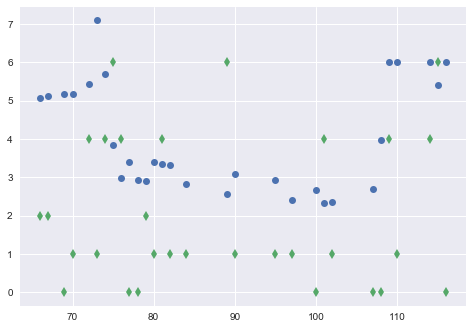

In [80]:
aa = dfm.copy()
aa["wpa"] = mwpa
aa["runRate"] = accRunRate
aa["wickets"] = accWickets
bb = aa[aa["batsman"]=="Yuvraj Singh"]
plt.plot(bb["wpa"]*12,'o')
#plt.figure()
plt.plot(bb["batsman_runs"],'d')

In [81]:
bb = aa[(aa["over"]==15) & (aa["inning"]==1)]
bb[["batsman_runs","wpa","runRate","wickets"]]

,batsman_runs,wpa,runRate,wickets
87,4,0.236093,96,2
88,1,0.237692,96,2
89,6,0.213615,99,2
90,1,0.257982,98,2
91,6,0.355477,101,2
92,1,0.354321,101,2


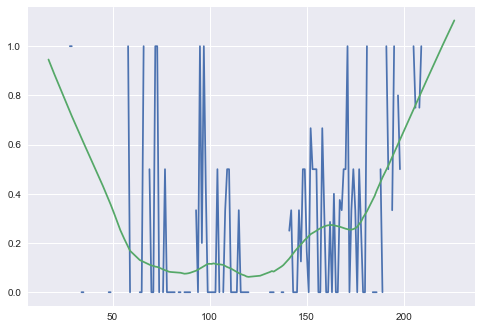

In [84]:
raw = we[:,99,2]
plt.plot(raw)
filtered = lowess(raw, range(len(raw)), is_sorted=True, frac=0.3)
plt.plot(filtered[:,0],filtered[:,1])

In [82]:
wpa

{'A Choudhary': -0.18180214687262539,
 'A Nehra': 0.10328197314842202,
 'B Kumar': -0.24999999999999625,
 'BCJ Cutting': -0.014772536989976076,
 'Bipul Sharma': 0.03004425196081062,
 'CH Gayle': 0.25000000000001088,
 'CJ Jordan (sub)': 4.8572257327350599e-15,
 'DA Warner': -0.019665716432120423,
 'DJ Hooda': -0.015504919390478003,
 'KM Jadhav': 0.14655032084599234,
 'MC Henriques': 0.026155193850953121,
 'Mandeep Singh': -0.071966276932928536,
 'Rashid Khan': 0.2519695492626039,
 'S Aravind': 0.32188882125272866,
 'S Dhawan': 0.012549253275734029,
 'SR Watson': -0.21890758154955098,
 'STR Binny': -0.11848033983523409,
 'Sachin Baby': -0.15771467158720465,
 'TM Head': -0.20848267719563102,
 'TS Mills': 0.43982198599720768,
 'YS Chahal': -0.26057409293122713,
 'Yuvraj Singh': -0.064390389877495652}

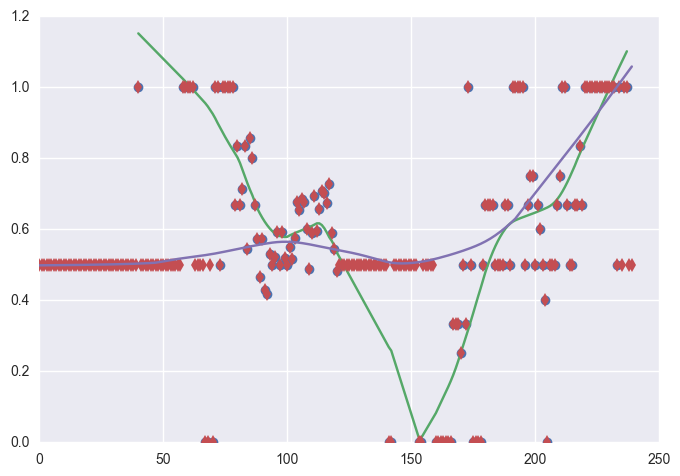

In [59]:
s = we[:,8,5]
plt.figure()
plt.plot(s,'o')
filtered = lowess(s, range(len(s)), is_sorted=True, frac=0.3)
plt.plot(filtered[:,0], filtered[:,1])
t = [0.5 if math.isnan(x) else x for x in s]
plt.plot(t,'d')
filtered = lowess(t, range(len(t)), is_sorted=True, frac=0.4)
plt.plot(filtered[:,0], filtered[:,1])


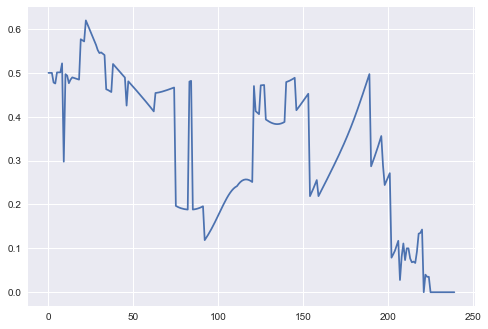

In [16]:
plt.plot(we1)
#plt.plot(range(len(filtered)), filtered[:,1])